# Car Price Predictor
This project takes data from multiple CSV files, taken from ~100,000 UK used car listings, and produces a linear regression model to predict a cars price from its features, such as make, model, mileage, etc.

## Import Local Dependencies
This project relys upon
* Pandas (Data Processing)
* Matplotlib (Visualisation)
* Numpy (Calculations)
* Scikit-learn (Machine Learning)

In [1]:
# Pandas
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

## Import Data
The data for this project is stored in multiple .csv files, in the data directory.

This block loads that data into one Pandas dataframe, while removing redundant data.

In [2]:
brands = ["audi", "bmw", "mercedes", "ford", "hyundi", "skoda", "toyota", "vauxhall", "vw"]

df = pd.DataFrame(columns=[
    "brand",
    "model", 
    "year", 
    "price", 
    "transmission", 
    "mileage", 
    "fuelType", 
    "engineSize", 
    "tax", 
    "mpg"
])

for brand in brands:
    loaded = pd.read_csv(f"./data/{brand}.csv")
    loaded["brand"] = str(brand)
    loaded["model"] = loaded["model"].str.lower()
    
    df = pd.concat([df, loaded])
    
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
df

,brand,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg
0,audi,a1,2017,12500,Manual,15735,Petrol,1.4,150,55.4
1,audi,a6,2016,16500,Automatic,36203,Diesel,2.0,20,64.2
2,audi,a1,2016,11000,Manual,29946,Petrol,1.4,30,55.4
3,audi,a4,2017,16800,Automatic,25952,Diesel,2.0,145,67.3
4,audi,a3,2019,17300,Manual,1998,Petrol,1.0,145,49.6
...,...,...,...,...,...,...,...,...,...,...
15152,vw,eos,2012,5990,Manual,74000,Diesel,2.0,125,58.9
15153,vw,fox,2008,1799,Manual,88102,Petrol,1.2,145,46.3
15154,vw,fox,2009,1590,Manual,70000,Petrol,1.4,200,42.0
15155,vw,fox,2006,1250,Manual,82704,Petrol,1.2,150,46.3


One issue is that many columns that are numeric are being represented as strings, and so can't be manipulated or calculated with. Thus, I need to cast them to numeric values, as well as doing some other processing.

In [3]:
df["year"] = df["year"].astype(int)
df["price"] = df["price"].astype(float)
df["mileage"] = df["mileage"].astype(int)
df["tax"] = df["tax"].astype(float)


df["transmission"] = pd.Categorical(df["transmission"])
df["t_type"] = df["transmission"].cat.codes


df["petrol"] = df["fuelType"].str.lower() == "Petrol"

In [4]:
df

,brand,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg,t_type,petrol
0,audi,a1,2017,12500.0,Manual,15735,Petrol,1.4,150.0,55.4,1,False
1,audi,a6,2016,16500.0,Automatic,36203,Diesel,2.0,20.0,64.2,0,False
2,audi,a1,2016,11000.0,Manual,29946,Petrol,1.4,30.0,55.4,1,False
3,audi,a4,2017,16800.0,Automatic,25952,Diesel,2.0,145.0,67.3,0,False
4,audi,a3,2019,17300.0,Manual,1998,Petrol,1.0,145.0,49.6,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
15152,vw,eos,2012,5990.0,Manual,74000,Diesel,2.0,125.0,58.9,1,False
15153,vw,fox,2008,1799.0,Manual,88102,Petrol,1.2,145.0,46.3,1,False
15154,vw,fox,2009,1590.0,Manual,70000,Petrol,1.4,200.0,42.0,1,False
15155,vw,fox,2006,1250.0,Manual,82704,Petrol,1.2,150.0,46.3,1,False


## Data Analysis

First, model the fluctuations in price over time for manual, semi-auto, and automatic cars

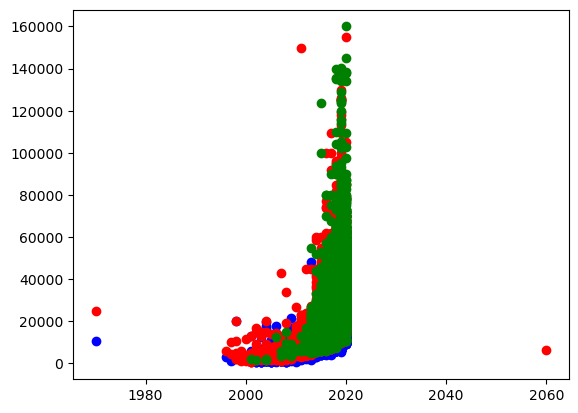

In [5]:
data = df.drop(df[ df["t_type"] == 2 ].index) # No "Other" transmission types

line_styles = {
    0: "red", # Automatic
    1: "blue", # Manual
    3: "green" # Semi-Auto
}

for t in data["t_type"].unique():
    xpoints = data[ data["t_type"] == t ]["year"]
    ypoints = data[ data["t_type"] == t ]["price"]
    plt.scatter(xpoints, ypoints, color = line_styles[t])

plt.show()

Newer cars sell for a far greater price, but it would seem Semi-Auto cars (plotted in green) lose their value faster, whereas automatics have kept their value over a longer value.

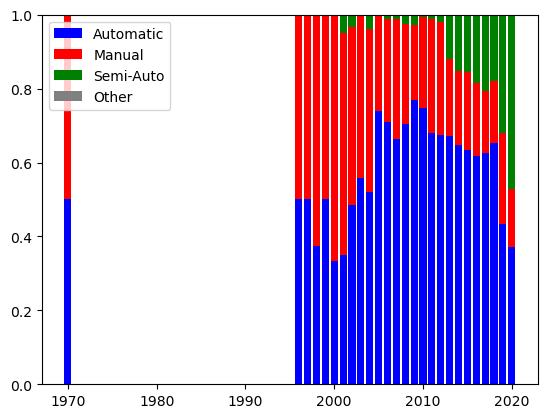

In [12]:
# Plot the proportion of each type sold over time

X = np.array( [i for i in range( df["year"].min(), df["year"].max() ) ] )

colours = {
    "Automatic": "red",
    "Manual": "blue",
    "Semi-Auto": "green",
    "Other": "grey"
}

for x in X:
    preportions = []
    year_data = df[ df["year"] == x ]
    if not year_data.empty:
        for t in df["transmission"].unique():
            preportions.append(len(year_data[ year_data["transmission"] == t ]) / len(year_data))
            plt.bar(x, preportions[-1], bottom=sum(preportions) - preportions[-1], color=colours[t] )
    
#     print(preportions)
            
plt.legend(["Automatic", "Manual", "Semi-Auto", "Other"])
plt.show()

This bar chart shows how many, as a proportion, of each transmission type are being sold from each year.

This chart shows that, of cars being sold, a majority of automatics are from ~2005 - 2018, whereas manuals are more prevalently from earlier (~1998). 

Semi-autos being sold only becomes more prevalent later on in the data, showing that this design is only starting to have an impact in the used car market.